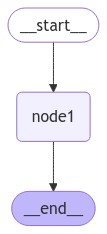

In [2]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image

class State(TypedDict):
    foo: int

def node1(state):
    print("Node1")
    return {"foo": state["foo"] + 1}

builder = StateGraph(State)

builder.add_node("node1", node1)

builder.add_edge(START, "node1")
builder.add_edge("node1", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
graph.invoke({"foo" : 1})

Node1


{'foo': 2}

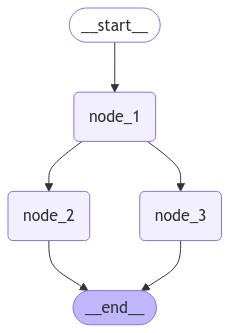

In [5]:
def node_1(state):
    print("Node1")
    return {"foo": state["foo"] + 1}

def node_2(state):
    print("Node1")
    return {"foo": state["foo"] + 1}

def node_3(state):
    print("Node1")
    return {"foo": state["foo"] + 1}

builder = StateGraph(State)

builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
from langgraph.errors import InvalidUpdateError

try: 
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(e)

Node1
Node1
Node1
At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


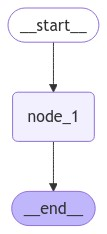

In [28]:
from operator import add
from typing import List

class State(TypedDict):
    foo: Annotated[List[int], add]

def node_1(state):
    print("NOde1")
    return {"foo": [state["foo"][0] + 1]}

builder = StateGraph(State)

builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")

builder.add_edge("node_1", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
graph.invoke({"foo" : [2]})

NOde1


{'foo': [2, 3]}

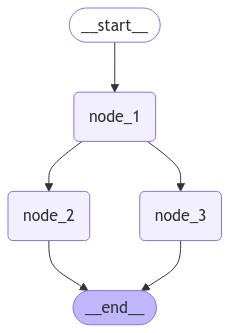

In [30]:
def node_1(state):
    print("Node1")
    return {"foo": [state["foo"][-1] + 1]}

def node_2(state):
    print("Node2")
    return {"foo": [state["foo"][-1] + 2]}

def node_3(state):
    print("Node3")
    return {"foo": [state["foo"][-1] + 3]}

builder = StateGraph(State)

builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
graph.invoke({"foo" : [1]})

Node1
Node2
Node3


{'foo': [1, 2, 4, 5]}

In [35]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(e)

can only concatenate list (not "NoneType") to list


## Custom REducers

- To Address cases like this, we can also defined custom reducers.
- For Example, let's define custom reducer logic to combine lists & handle cases where either or both of the inputs might be *None*

In [ ]:
def custom_reducers(left: List | None, right: List | None) -> List:
    """"Safely Combine two lists, handling cases where either or both inputs might be None.
    
    Args:
        left (List | None): The first list to be combined.
        right (List | None): The second list to be combined.

    Returns:
        List: A new list containing all elements from both input lists.
                if an Input is None, it's treated as an empty list.
    """
    # If left is None, use an empty list; otherwise, use left
    left = [] if left is None else left
    # If right is None, use an empty list; otherwise, use right
    if not right:
        right = []
    # Combine the two lists and return the result
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[List[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[List[int], custom_reducers]

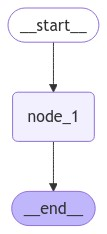

can only concatenate list (not "NoneType") to list


In [50]:
def node_1(state):
    print("Node_1")
    return {"foo" : [5]}

builder = StateGraph(DefaultState)

builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

try: 
    graph.invoke({"foo" : None})
except TypeError as e:
    print(e)

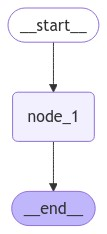

Node_1
{'foo': [5]}


In [53]:
builder = StateGraph(CustomReducerState)

builder.add_node("node_1", node_1)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

try: 
    response = graph.invoke({"foo" : None})
    print(response)
except TypeError as e:
    print(e)

In [54]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import  add_messages, MessagesState
import operator
from typing import List

class CustomMessagesState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    added_key: str
    added_key2: str

class ExtendMessagesState(MessagesState):
    added_key: str
    added_key2: str

In [56]:
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph.message import add_messages

initial_messages = [HumanMessage(content="Hello, how are you?"),
                    AIMessage(content="I'm doing well, thanks!")]

updated_messages = add_messages(
    initial_messages,
    [HumanMessage(content="How's the weather today?"), AIMessage(content="It's sunny and warm today.")],
)
updated_messages

[HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='52eed87f-1eed-4550-85a2-3210c2e07bc4'),
 AIMessage(content="I'm doing well, thanks!", additional_kwargs={}, response_metadata={}, id='5f45e77e-0a07-47c7-a25c-96619e0c920c'),
 HumanMessage(content="How's the weather today?", additional_kwargs={}, response_metadata={}, id='1e93bb3c-e45d-4a1a-806b-af5e4817fb95'),
 AIMessage(content="It's sunny and warm today.", additional_kwargs={}, response_metadata={}, id='a6338f9f-a2d0-487f-abe2-d33ea30a889b')]

In [57]:
initial_messages = [HumanMessage(content="Hello, how are you?", id=0),
                    AIMessage(content="I'm doing well, thanks!", id=1)]

updated_messages = add_messages(
    initial_messages,
    [HumanMessage(content="How's the weather today?", id=3), AIMessage(content="It's sunny and warm today.", id=4)],
)
updated_messages

[HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='0'),
 AIMessage(content="I'm doing well, thanks!", additional_kwargs={}, response_metadata={}, id='1'),
 HumanMessage(content="How's the weather today?", additional_kwargs={}, response_metadata={}, id='3'),
 AIMessage(content="It's sunny and warm today.", additional_kwargs={}, response_metadata={}, id='4')]

In [58]:
from langgraph.graph.message import RemoveMessage

remove_message = [RemoveMessage(msg.id) for msg in updated_messages[:-2]]
print(remove_message)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='0'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1')]


In [59]:
add_messages(updated_messages, remove_message)

[HumanMessage(content="How's the weather today?", additional_kwargs={}, response_metadata={}, id='3'),
 AIMessage(content="It's sunny and warm today.", additional_kwargs={}, response_metadata={}, id='4')]